In [12]:
!pip install -q kaggle
# downloads to /content
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia -p /content

Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
License(s): other
 99% 2.28G/2.29G [00:35<00:00, 61.2MB/s]
100% 2.29G/2.29G [00:35<00:00, 69.0MB/s]


In [13]:
!unzip -q chest-xray-pneumonia.zip -d /content/raw_data

import shutil, os

raw = "/content/raw_data/chest_xray"
target = "/content/chest_xray"
os.makedirs(target, exist_ok=True)

for folder in ["train", "test", "val"]:
    shutil.move(f"{raw}/{folder}", f"{target}/{folder}")

In [14]:
!find /content/chest_xray -maxdepth 2 -type d -print

/content/chest_xray
/content/chest_xray/test
/content/chest_xray/test/PNEUMONIA
/content/chest_xray/test/NORMAL
/content/chest_xray/train
/content/chest_xray/train/PNEUMONIA
/content/chest_xray/train/NORMAL
/content/chest_xray/val
/content/chest_xray/val/PNEUMONIA
/content/chest_xray/val/NORMAL


### Data Generators (Medical Augmentation Safe)

In [15]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_SIZE = 224
BATCH = 32

train_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    zoom_range=0.1,
    width_shift_range=0.05,
    height_shift_range=0.05,
    brightness_range=[0.8,1.2],
)

val_test_gen = ImageDataGenerator(rescale=1./255)

train = train_gen.flow_from_directory(
    "/content/chest_xray/train",
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH,
    class_mode='binary'
)

val = val_test_gen.flow_from_directory(
    "/content/chest_xray/val",
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH,
    class_mode='binary'
)

test = val_test_gen.flow_from_directory(
    "/content/chest_xray/test",
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH,
    class_mode='binary',
    shuffle=False
)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


### Build DenseNet121 Model (Warm-up Stage)

In [16]:
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

base = DenseNet121(weights='imagenet', include_top=False, input_shape=(224,224,3))
base.trainable = False  # freeze for warm-up

x = GlobalAveragePooling2D()(base.output)
x = Dropout(0.3)(x)
output = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base.input, outputs=output)

model.compile(
    optimizer=Adam(1e-3),
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
)

model.summary()

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,408 │ zero_padding2d[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 56, 56,    │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 56, 56,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 56, 56,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 56, 56,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 56, 56,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 56, 56,    │     12,288 │ conv2_block2_0_r

 Total params: 7,038,529 (26.85 MB)

 Trainable params: 1,025 (4.00 KB)

 Non-trainable params: 7,037,504 (26.85 MB)

### Warm-Up Training

In [17]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

callbacks = [
    EarlyStopping(patience=3, restore_best_weights=True),
    ModelCheckpoint("best_warmup.h5", save_best_only=True)
]

history1 = model.fit(
    train,
    validation_data=val,
    epochs=8,
    callbacks=callbacks
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/8
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 764ms/step - accuracy: 0.7958 - auc: 0.7946 - loss: 0.4549

163/163 ━━━━━━━━━━━━━━━━━━━━ 178s 882ms/step - accuracy: 0.7961 - auc: 0.7952 - loss: 0.4543 - val_accuracy: 0.8125 - val_auc: 0.9375 - val_loss: 0.4211
Epoch 2/8
163/163 ━━━━━━━━━━━━━━━━━━━━ 123s 756ms/step - accuracy: 0.9117 - auc: 0.9597 - loss: 0.2336 - val_accuracy: 0.8125 - val_auc: 0.9297 - val_loss: 0.4472
Epoch 3/8
163/163 ━━━━━━━━━━━━━━━━━━━━ 125s 767ms/step - accuracy: 0.9170 - auc: 0.9637 - loss: 0.2115 - val_accuracy: 0.7500 - val_auc: 0.9531 - val_loss: 0.4562
Epoch 4/8
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 770ms/step - accuracy: 0.9277 - auc: 0.9694 - loss: 0.1966

163/163 ━━━━━━━━━━━━━━━━━━━━ 127s 780ms/step - accuracy: 0.9277 - auc: 0.9694 - loss: 0.1966 - val_accuracy: 0.8125 - val_auc: 0.9531 - val_loss: 0.3814
Epoch 5/8
163/163 ━━━━━━━━━━━━━━━━━━━━ 124s 755ms/step - accuracy: 0.9273 - auc: 0.9775 - loss: 0.1734 - val_accuracy: 0.8125 - val_auc: 0.9609 - val_loss: 0.4458
Epoch 6/8
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 765ms/step - accuracy: 0.9314 - auc: 0.9768 - loss: 0.1717

163/163 ━━━━━━━━━━━━━━━━━━━━ 145s 775ms/step - accuracy: 0.9314 - auc: 0.9768 - loss: 0.1717 - val_accuracy: 0.8125 - val_auc: 0.9844 - val_loss: 0.3292
Epoch 7/8
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 749ms/step - accuracy: 0.9354 - auc: 0.9758 - loss: 0.1737

163/163 ━━━━━━━━━━━━━━━━━━━━ 123s 757ms/step - accuracy: 0.9354 - auc: 0.9758 - loss: 0.1737 - val_accuracy: 0.8125 - val_auc: 0.9844 - val_loss: 0.3093
Epoch 8/8
163/163 ━━━━━━━━━━━━━━━━━━━━ 122s 749ms/step - accuracy: 0.9367 - auc: 0.9742 - loss: 0.1670 - val_accuracy: 0.8125 - val_auc: 0.9922 - val_loss: 0.4071


### Fine-Tune Last 30 Layers

In [18]:
for layer in base.layers[-30:]:
    layer.trainable = True

model.compile(
    optimizer=Adam(1e-5),
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
)

callbacks_ft = [
    EarlyStopping(patience=4, restore_best_weights=True),
    ModelCheckpoint("best_densenet121.h5", save_best_only=True)
]

history2 = model.fit(
    train,
    validation_data=val,
    epochs=20,
    callbacks=callbacks_ft
)

Epoch 1/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 750ms/step - accuracy: 0.8651 - auc: 0.9521 - loss: 0.3766

163/163 ━━━━━━━━━━━━━━━━━━━━ 177s 856ms/step - accuracy: 0.8653 - auc: 0.9521 - loss: 0.3762 - val_accuracy: 0.6875 - val_auc: 0.9375 - val_loss: 0.6852
Epoch 2/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 126s 775ms/step - accuracy: 0.9327 - auc: 0.9757 - loss: 0.1906 - val_accuracy: 0.6875 - val_auc: 0.9375 - val_loss: 0.7519
Epoch 3/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 783ms/step - accuracy: 0.9264 - auc: 0.9711 - loss: 0.2049

163/163 ━━━━━━━━━━━━━━━━━━━━ 129s 793ms/step - accuracy: 0.9265 - auc: 0.9711 - loss: 0.2048 - val_accuracy: 0.8125 - val_auc: 0.9453 - val_loss: 0.5814
Epoch 4/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 781ms/step - accuracy: 0.9362 - auc: 0.9782 - loss: 0.1776

163/163 ━━━━━━━━━━━━━━━━━━━━ 129s 789ms/step - accuracy: 0.9362 - auc: 0.9782 - loss: 0.1776 - val_accuracy: 0.8125 - val_auc: 0.9922 - val_loss: 0.4624
Epoch 5/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 781ms/step - accuracy: 0.9399 - auc: 0.9792 - loss: 0.1618

163/163 ━━━━━━━━━━━━━━━━━━━━ 129s 789ms/step - accuracy: 0.9399 - auc: 0.9792 - loss: 0.1619 - val_accuracy: 0.8125 - val_auc: 1.0000 - val_loss: 0.3845
Epoch 6/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 789ms/step - accuracy: 0.9454 - auc: 0.9801 - loss: 0.1551

163/163 ━━━━━━━━━━━━━━━━━━━━ 130s 798ms/step - accuracy: 0.9454 - auc: 0.9801 - loss: 0.1551 - val_accuracy: 0.8125 - val_auc: 1.0000 - val_loss: 0.3264
Epoch 7/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 777ms/step - accuracy: 0.9523 - auc: 0.9850 - loss: 0.1295

163/163 ━━━━━━━━━━━━━━━━━━━━ 128s 786ms/step - accuracy: 0.9522 - auc: 0.9849 - loss: 0.1297 - val_accuracy: 0.8125 - val_auc: 1.0000 - val_loss: 0.2802
Epoch 8/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 781ms/step - accuracy: 0.9432 - auc: 0.9776 - loss: 0.1601

163/163 ━━━━━━━━━━━━━━━━━━━━ 129s 792ms/step - accuracy: 0.9432 - auc: 0.9777 - loss: 0.1600 - val_accuracy: 0.8750 - val_auc: 1.0000 - val_loss: 0.2224
Epoch 9/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 779ms/step - accuracy: 0.9443 - auc: 0.9834 - loss: 0.1475

163/163 ━━━━━━━━━━━━━━━━━━━━ 128s 787ms/step - accuracy: 0.9443 - auc: 0.9834 - loss: 0.1476 - val_accuracy: 0.8750 - val_auc: 1.0000 - val_loss: 0.2087
Epoch 10/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 710ms/step - accuracy: 0.9464 - auc: 0.9826 - loss: 0.1499

163/163 ━━━━━━━━━━━━━━━━━━━━ 117s 718ms/step - accuracy: 0.9464 - auc: 0.9826 - loss: 0.1498 - val_accuracy: 0.8750 - val_auc: 1.0000 - val_loss: 0.1841
Epoch 11/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 695ms/step - accuracy: 0.9470 - auc: 0.9863 - loss: 0.1328

163/163 ━━━━━━━━━━━━━━━━━━━━ 114s 702ms/step - accuracy: 0.9470 - auc: 0.9863 - loss: 0.1328 - val_accuracy: 0.8750 - val_auc: 1.0000 - val_loss: 0.1675
Epoch 12/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 682ms/step - accuracy: 0.9567 - auc: 0.9848 - loss: 0.1297

163/163 ━━━━━━━━━━━━━━━━━━━━ 113s 689ms/step - accuracy: 0.9567 - auc: 0.9848 - loss: 0.1297 - val_accuracy: 1.0000 - val_auc: 1.0000 - val_loss: 0.1161
Epoch 13/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 688ms/step - accuracy: 0.9578 - auc: 0.9875 - loss: 0.1192

163/163 ━━━━━━━━━━━━━━━━━━━━ 113s 695ms/step - accuracy: 0.9578 - auc: 0.9875 - loss: 0.1192 - val_accuracy: 1.0000 - val_auc: 1.0000 - val_loss: 0.1028
Epoch 14/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 683ms/step - accuracy: 0.9475 - auc: 0.9854 - loss: 0.1321

163/163 ━━━━━━━━━━━━━━━━━━━━ 113s 693ms/step - accuracy: 0.9475 - auc: 0.9854 - loss: 0.1322 - val_accuracy: 1.0000 - val_auc: 1.0000 - val_loss: 0.0960
Epoch 15/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 680ms/step - accuracy: 0.9512 - auc: 0.9878 - loss: 0.1205

163/163 ━━━━━━━━━━━━━━━━━━━━ 112s 687ms/step - accuracy: 0.9512 - auc: 0.9878 - loss: 0.1205 - val_accuracy: 1.0000 - val_auc: 1.0000 - val_loss: 0.0840
Epoch 16/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 683ms/step - accuracy: 0.9607 - auc: 0.9896 - loss: 0.1111

163/163 ━━━━━━━━━━━━━━━━━━━━ 113s 690ms/step - accuracy: 0.9607 - auc: 0.9896 - loss: 0.1112 - val_accuracy: 1.0000 - val_auc: 1.0000 - val_loss: 0.0830
Epoch 17/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 686ms/step - accuracy: 0.9529 - auc: 0.9870 - loss: 0.1175

163/163 ━━━━━━━━━━━━━━━━━━━━ 113s 694ms/step - accuracy: 0.9529 - auc: 0.9871 - loss: 0.1175 - val_accuracy: 1.0000 - val_auc: 1.0000 - val_loss: 0.0761
Epoch 18/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 682ms/step - accuracy: 0.9542 - auc: 0.9906 - loss: 0.1162

163/163 ━━━━━━━━━━━━━━━━━━━━ 112s 689ms/step - accuracy: 0.9542 - auc: 0.9906 - loss: 0.1161 - val_accuracy: 1.0000 - val_auc: 1.0000 - val_loss: 0.0654
Epoch 19/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 690ms/step - accuracy: 0.9670 - auc: 0.9902 - loss: 0.0976

163/163 ━━━━━━━━━━━━━━━━━━━━ 114s 698ms/step - accuracy: 0.9669 - auc: 0.9902 - loss: 0.0977 - val_accuracy: 1.0000 - val_auc: 1.0000 - val_loss: 0.0644
Epoch 20/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 686ms/step - accuracy: 0.9624 - auc: 0.9919 - loss: 0.0969

163/163 ━━━━━━━━━━━━━━━━━━━━ 114s 693ms/step - accuracy: 0.9624 - auc: 0.9919 - loss: 0.0969 - val_accuracy: 1.0000 - val_auc: 1.0000 - val_loss: 0.0626


### Dynamic Plotting (Fixed Keys)

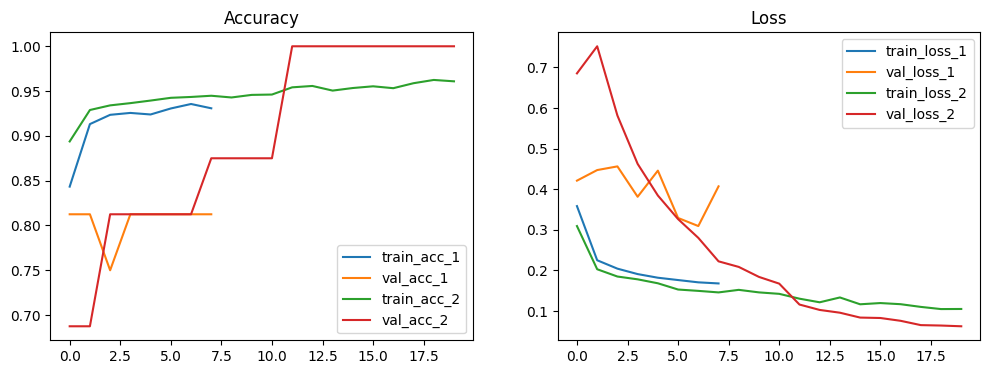

In [19]:
import matplotlib.pyplot as plt

def plot_history(*histories):
    plt.figure(figsize=(12,4))

    # Accuracy
    plt.subplot(1,2,1)
    for i,h in enumerate(histories):
        acc = [k for k in h.history.keys() if "accuracy" in k and not k.startswith("val")][0]
        val_acc = [k for k in h.history.keys() if "val" in k and "accuracy" in k][0]
        plt.plot(h.history[acc], label=f"train_acc_{i+1}")
        plt.plot(h.history[val_acc], label=f"val_acc_{i+1}")
    plt.legend()
    plt.title("Accuracy")

    # Loss
    plt.subplot(1,2,2)
    for i,h in enumerate(histories):
        plt.plot(h.history['loss'], label=f"train_loss_{i+1}")
        plt.plot(h.history['val_loss'], label=f"val_loss_{i+1}")
    plt.legend()
    plt.title("Loss")

    plt.show()

plot_history(history1, history2)

### Evaluate

In [20]:
test_loss, test_acc, test_auc = model.evaluate(test)
print("Test Accuracy:", test_acc)
print("Test AUC:", test_auc)

20/20 ━━━━━━━━━━━━━━━━━━━━ 14s 252ms/step - accuracy: 0.8308 - auc: 0.6342 - loss: 0.5611
Test Accuracy: 0.8926281929016113
Test AUC: 0.953292727470398


### Confusion Matrix + Classification Report

In [21]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

pred = model.predict(test)
pred_labels = (pred > 0.5).astype(int)

cm = confusion_matrix(test.classes, pred_labels)
print(cm)

print(classification_report(test.classes, pred_labels, target_names=["NORMAL","PNEUMONIA"]))

20/20 ━━━━━━━━━━━━━━━━━━━━ 33s 892ms/step
[[171  63]
 [  4 386]]
              precision    recall  f1-score   support

      NORMAL       0.98      0.73      0.84       234
   PNEUMONIA       0.86      0.99      0.92       390

    accuracy                           0.89       624
   macro avg       0.92      0.86      0.88       624
weighted avg       0.90      0.89      0.89       624

